In [1547]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from PIL import Image
from scipy import signal
import cv2
import os
import glob
import random
import argparse

class UglyImage:
    
    def __init__(self, path = 'C:/Users/1611204/Desktop/Workshop/IMG250/', image_size=(512,512)):
        self.path=path
        self.image_size=image_size
        
    def loadImg(self, batch_size = 1, blackWhiteImg = False):

        while(1):
            colorRoll = 1    #0001
            distort = 2      #0010
            greenPinkBar = 4 #0100
            parsyte = 8      #1000
            imgs_clean = []
            imgs_ugly = []
            for filename in random.choices(glob.glob(self.path + '*.*'), k=batch_size):
                degradationDecision = random.randrange(0,16)
                img = cv2.imread(filename)
                img = cv2.resize(img, self.image_size)
                imgs_clean.append(img)
                img_ugly = img
                img_ugly = self.posterisation(img_ugly,32,30)
                img_ugly = self.noise(img_ugly,30)
                if(blackWhiteImg):
                    img_ugly = self.blackWhite(img_ugly)
                if((degradationDecision & colorRoll) == colorRoll):
                    img_ugly = self.colorRoll(img_ugly,5)
                if((degradationDecision & distort) == distort):
                    img_ugly = self.artefacts2(img_ugly)
                if((degradationDecision & greenPinkBar) == greenPinkBar):
                    img_ugly = self.artefacts3(img_ugly)
                if((degradationDecision & parsyte) == parsyte):
                    img_ugly = self.artefacts(img_ugly)
                imgs_ugly.append(img_ugly)
        
            yield imgs_ugly, imgs_clean
       
    def colorRoll(self, image, rollPix):
        r = image[:,:,0:1]
        g = image[:,:,1:2]
        b = image[:,:,2:3]
        r = np.roll(r,random.randrange(-rollPix,rollPix))
        g = np.roll(g,random.randrange(-rollPix,rollPix))
        b = np.roll(b,random.randrange(-rollPix,rollPix))
        imagereturn = np.concatenate((r,g,b),axis=2)
        return imagereturn
        return image
    
    def posterisation(self,image,nbColor,cutLowColor):
        r = image[:,:,0:1]
        g = image[:,:,1:2]
        b = image[:,:,2:3]
        r = self.reduceColor(r,nbColor,cutLowColor)
        g = self.reduceColor(g,nbColor,cutLowColor)
        b = self.reduceColor(b,nbColor,cutLowColor)
        imagereturn = np.concatenate((r,g,b),axis=2)
        return imagereturn
    
    def reduceColor(self, array, nuances,cutLowColor):
        compressVal = 255/nuances
        array = array/compressVal
        array[array < (cutLowColor/compressVal)] = cutLowColor/compressVal
        for line in range(0,len(array)):
            array[line] = np.ceil(array[line])
        return np.array(np.ceil(array*compressVal), dtype='int')
        
    def artefacts(self, image):
        matrixConv1 = [[0, 1, 0],[4, 0, 4],[0, 1, 0]]
        randomColor = random.randrange(1,7)
        lineStart = random.randrange(0,image.shape[0]-2)
        r = image[:,:,0:1]
        g = image[:,:,1:2]
        b = image[:,:,2:3]
        r = r.transpose(2,0,1).reshape(r.shape[0],r.shape[1])
        g = g.transpose(2,0,1).reshape(g.shape[0],g.shape[1])
        b = b.transpose(2,0,1).reshape(b.shape[0],b.shape[1])
        rsin = []
        gsin = []
        bsin = []
        rsin = signal.convolve2d(r[lineStart: lineStart+2,:], matrixConv1)
        gsin = signal.convolve2d(g[lineStart: lineStart+2,:], matrixConv1)
        bsin = signal.convolve2d(b[lineStart: lineStart+2,:], matrixConv1)
        r[lineStart: lineStart+2,:] =  np.resize(rsin,(2,r.shape[1]))
        g[lineStart: lineStart+2,:] =  np.resize(rsin,(2,g.shape[1]))
        b[lineStart: lineStart+2,:] =  np.resize(rsin,(2,b.shape[1]))
        r = np.reshape(r, r.shape + (1,))
        g = np.reshape(g, g.shape + (1,))
        b = np.reshape(b, b.shape + (1,))
        r = np.resize(r,(r.shape[0], r.shape[1], 1))
        g = np.resize(g,(g.shape[0], g.shape[1], 1))
        b = np.resize(b,(b.shape[0], b.shape[1], 1))
        imagereturn = np.concatenate((r,g,b),axis=2)
        return imagereturn
    
    def artefacts2(self, image):
        lineStart = random.randrange(0,image.shape[0]-10)
        lineEnd = lineStart + random.randrange(4,29)
        for i in range(0 , lineEnd - lineStart):
            j = lineEnd - lineStart - i
            image[lineStart-j] = np.roll(image[lineStart-j],j*random.randrange(3,6,3))
        return image
    
    def artefacts3(self, image):
        randomColor = random.randrange(1,3)
        lineEnd = random.randrange(75, 100)
        for i in range(0 , lineEnd):
            if(randomColor == 1):
                image[i,:,0] = 0
                image[i,:,2] = 0
            if(randomColor == 2):
                image[i,:,1] = 0
        return image
    
    def noise(self, image, noiseReduction):
        noise = np.random.randint(0,2,(image.shape[1],image.shape[0],image.shape[2]))*-noiseReduction
        noise = np.reshape(noise, noise.shape + (1,))
        noise = np.repeat(noise[:,:,0], 3, axis=2)
        result = image + noise
        return result
    
    def blackWhite(self, image):
        image = np.array(image, dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        return image
    
    def printImg(self, image):
        image = np.array(image, dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
        plt.show


UI =UglyImage() 
gen = UI.loadImg(1,True)

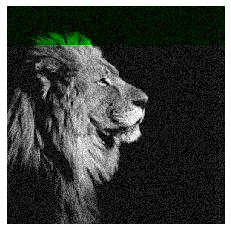

In [1545]:
array_ugly, array_clean= next(gen)
UI.printImg(array_ugly[0])

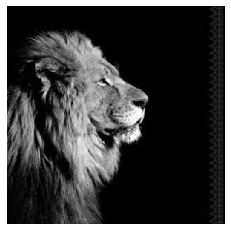

In [1387]:
UI.printImg(array_clean[0])